# Import necessary libraries

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from yellowbrick.classifier import ConfusionMatrix

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [2]:
df=pd.read_csv("/kaggle/input/breast-cancer-dataset-used-royston-and-altman/gbsg.csv")
df

,Unnamed: 0,pid,age,meno,size,grade,nodes,pgr,er,hormon,rfstime,status
0,1,132,49,0,18,2,2,0,0,0,1838,0
1,2,1575,55,1,20,3,16,0,0,0,403,1
2,3,1140,56,1,40,3,3,0,0,0,1603,0
3,4,769,45,0,25,3,1,0,4,0,177,0
4,5,130,65,1,30,2,5,0,36,1,1855,0
...,...,...,...,...,...,...,...,...,...,...,...,...
681,682,586,51,0,30,3,2,1152,38,1,1760,0
682,683,1273,64,1,26,2,2,1356,1144,1,1152,0
683,684,1525,57,1,35,3,1,1490,209,1,1342,0
684,685,736,44,0,21,2,3,1600,70,0,629,0


# Data analysis

#### Drop the columns that have unique values

In [3]:
df=df.drop(['Unnamed: 0','pid'],axis=1)

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 686 entries, 0 to 685
Data columns (total 10 columns):
 #   Column   Non-Null Count  Dtype
---  ------   --------------  -----
 0   age      686 non-null    int64
 1   meno     686 non-null    int64
 2   size     686 non-null    int64
 3   grade    686 non-null    int64
 4   nodes    686 non-null    int64
 5   pgr      686 non-null    int64
 6   er       686 non-null    int64
 7   hormon   686 non-null    int64
 8   rfstime  686 non-null    int64
 9   status   686 non-null    int64
dtypes: int64(10)
memory usage: 53.7 KB


In [6]:
df.describe()

,age,meno,size,grade,nodes,pgr,er,hormon,rfstime,status
count,686.000000,686.000000,686.000000,686.000000,686.000000,686.000000,686.000000,686.000000,686.000000,686.000000
mean,53.052478,0.577259,29.329446,2.116618,5.010204,109.995627,96.252187,0.358601,1124.489796,0.435860
std,10.120739,0.494355,14.296217,0.582808,5.475483,202.331552,153.083963,0.479940,642.791948,0.496231
min,21.000000,0.000000,3.000000,1.000000,1.000000,0.000000,0.000000,0.000000,8.000000,0.000000
25%,46.000000,0.000000,20.000000,2.000000,1.000000,7.000000,8.000000,0.000000,567.750000,0.000000
50%,53.000000,1.000000,25.000000,2.000000,3.000000,32.500000,36.000000,0.000000,1084.000000,0.000000
75%,61.000000,1.000000,35.000000,2.000000,7.000000,131.750000,114.000000,1.000000,1684.750000,1.000000
max,80.000000,1.000000,120.000000,3.000000,51.000000,2380.000000,1144.000000,1.000000,2659.000000,1.000000


In [7]:
df.dtypes

age        int64
meno       int64
size       int64
grade      int64
nodes      int64
pgr        int64
er         int64
hormon     int64
rfstime    int64
status     int64
dtype: object

#### Checking the null values

In [8]:
df.isnull().sum()

age        0
meno       0
size       0
grade      0
nodes      0
pgr        0
er         0
hormon     0
rfstime    0
status     0
dtype: int64

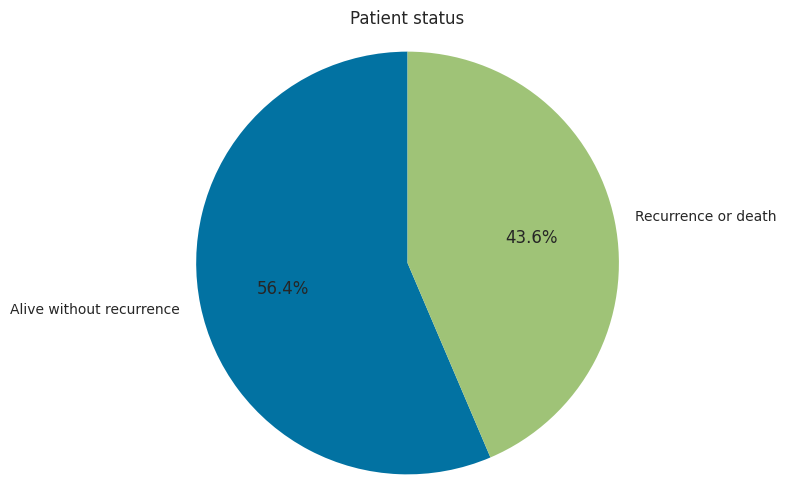

In [9]:
plt.figure(figsize=(6,6))
status_counts=df['status'].value_counts()
labels=['Alive without recurrence','Recurrence or death']
plt.pie(status_counts,labels=labels,startangle=90,autopct='%.1f%%')
plt.title("Patient status")
plt.axis('equal')
plt.show()

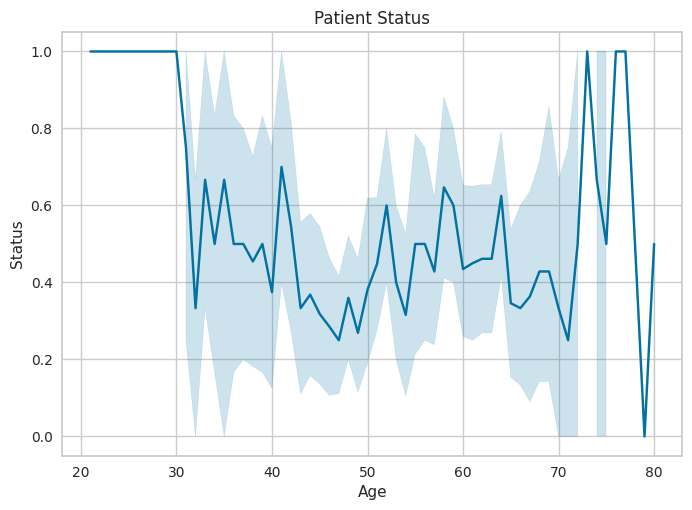

In [10]:
sns.lineplot(x='age',y='status',data=df)
plt.title('Patient Status')
plt.xlabel('Age')
plt.ylabel("Status")
plt.show()

In [11]:
def plot_hist(data,columns):
  fig,axes=plt.subplots(nrows=len(columns),ncols=1,figsize=(20,20))
  for i,col in enumerate(columns):
    sns.histplot(data[col],kde=False,ax=axes[i])
    axes[i].set_xlabel(col)
  plt.tight_layout()
  plt.show()

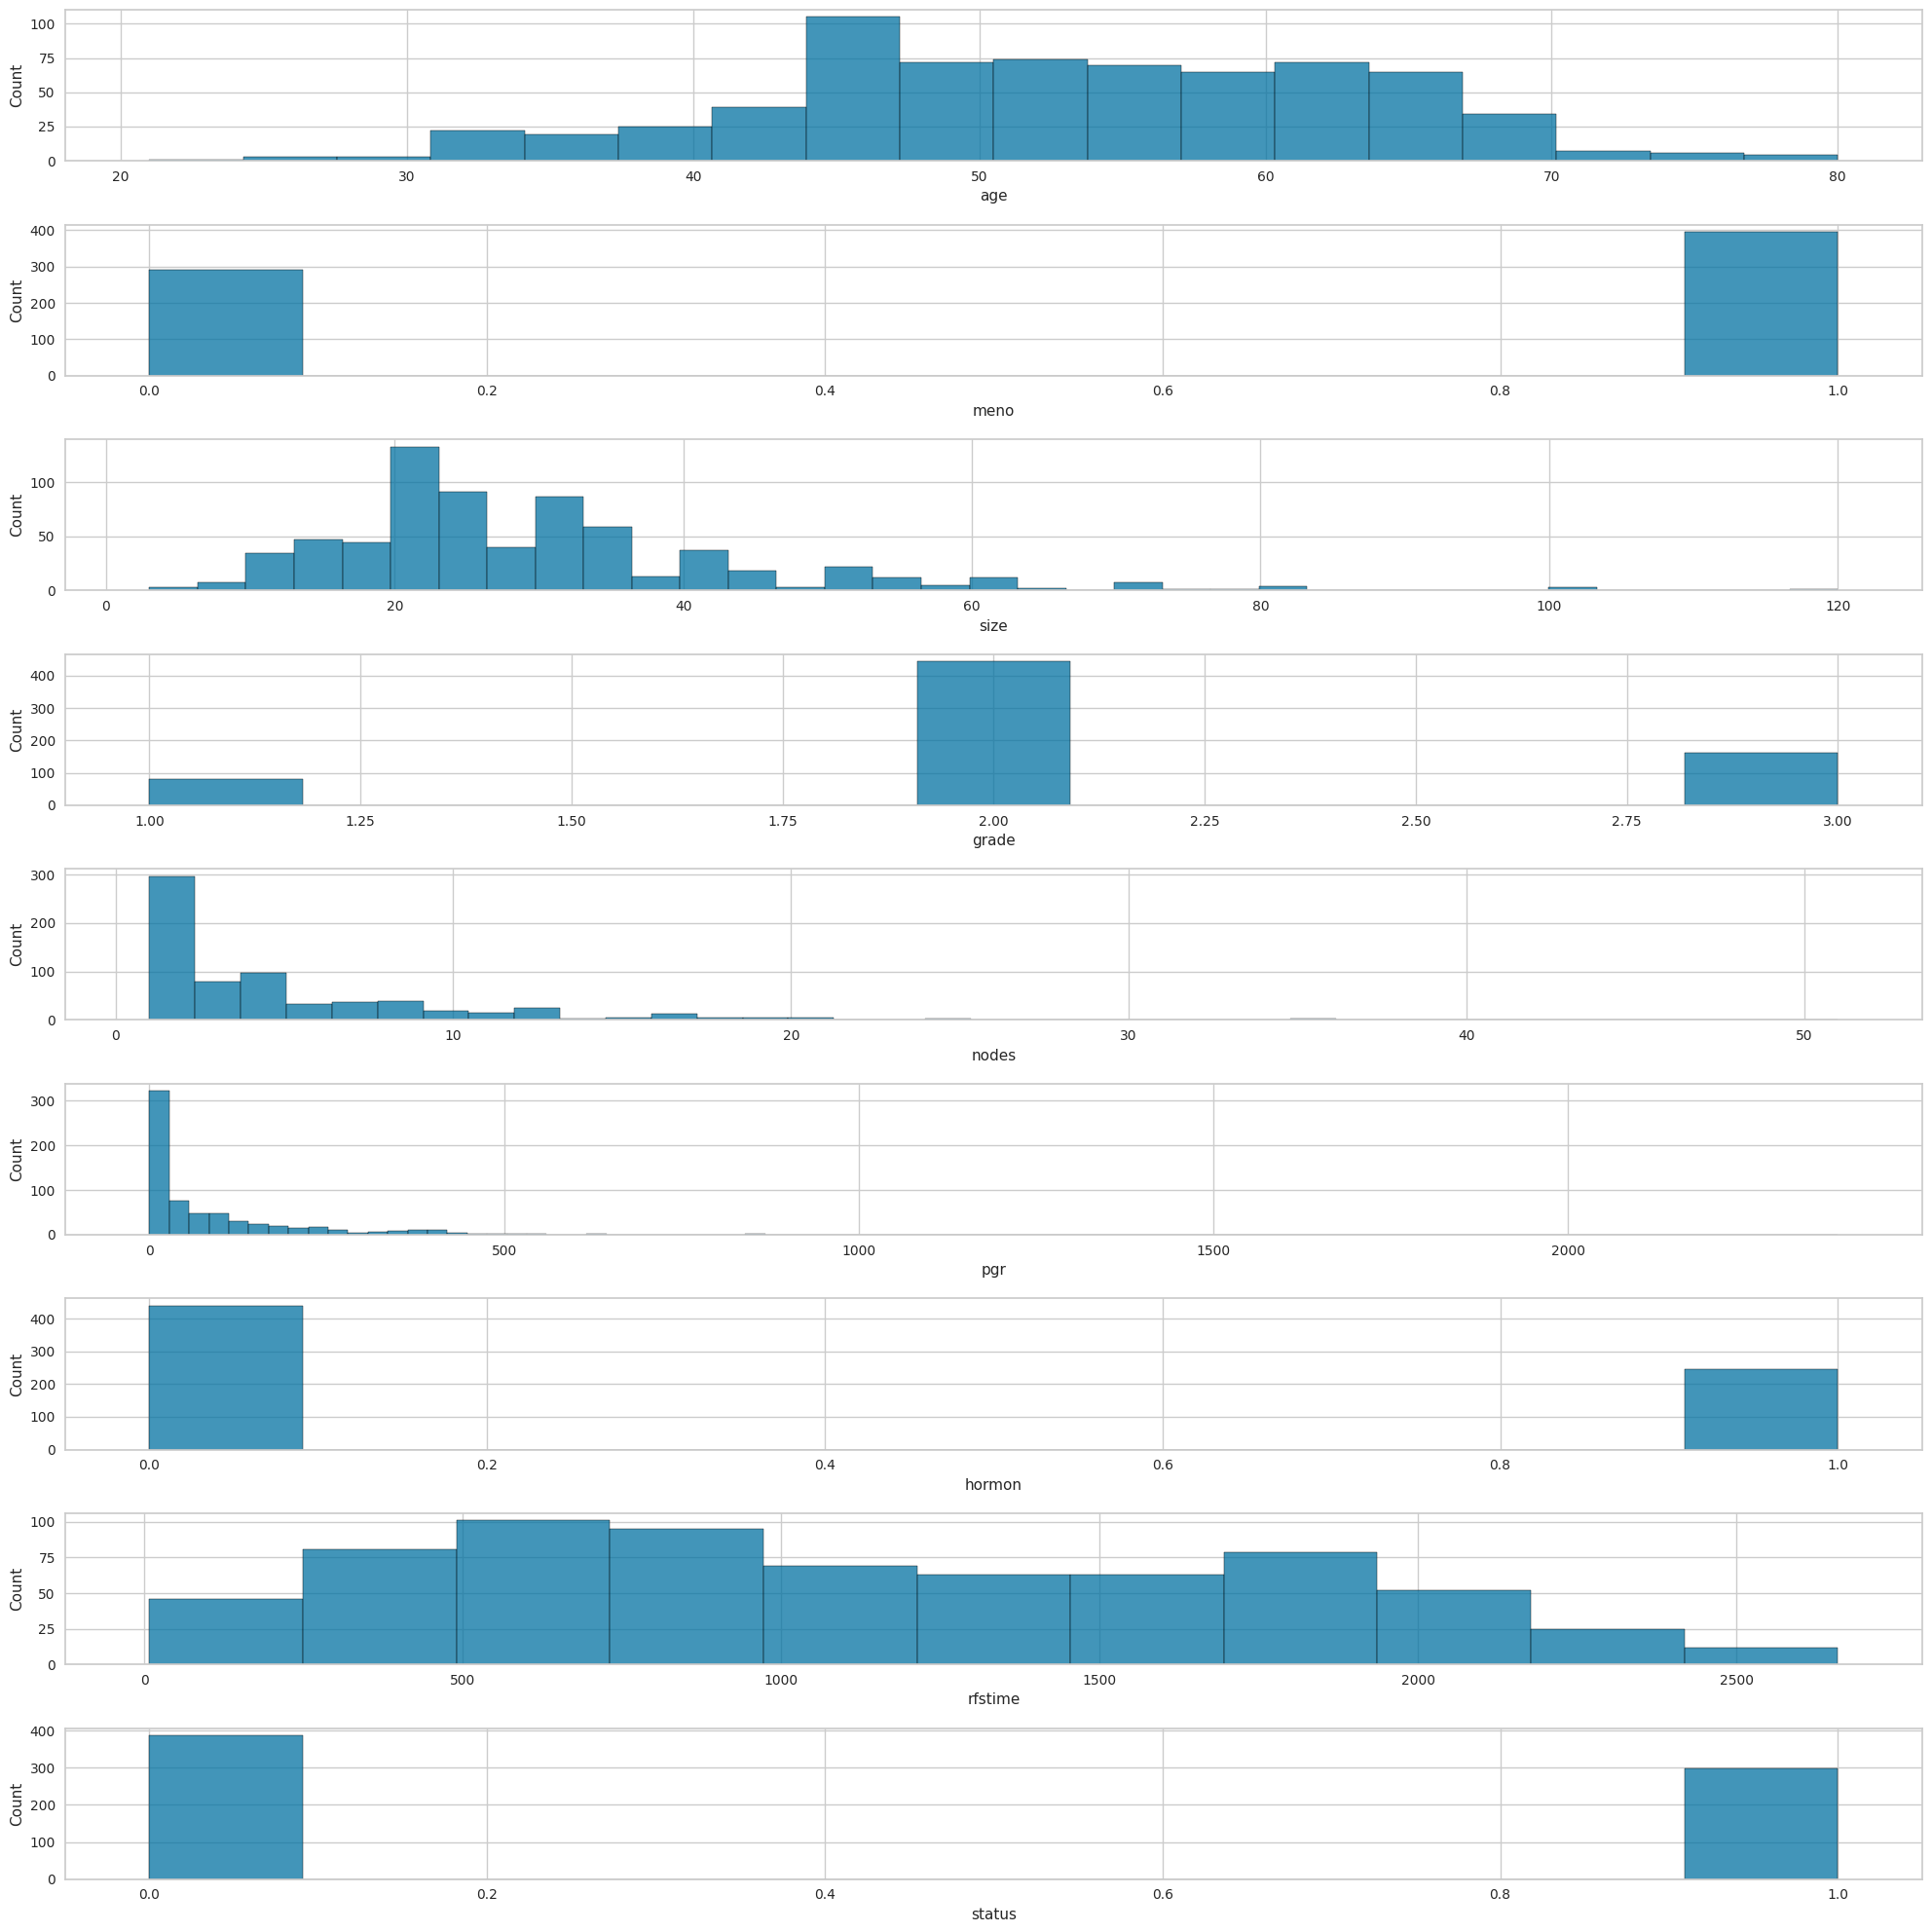

In [12]:
col=['age','meno','size','grade','nodes','pgr','hormon','rfstime','status']
plot_hist(df,col)

In [13]:
def box_plot(data, columns):
    fig, axes = plt.subplots(nrows=len(columns), ncols=1, figsize=(20,25))
    for i, col in enumerate(columns):
        sns.boxplot(data[col], ax=axes[i])
        axes[i].set_xlabel(col)
    plt.tight_layout()
    plt.show()

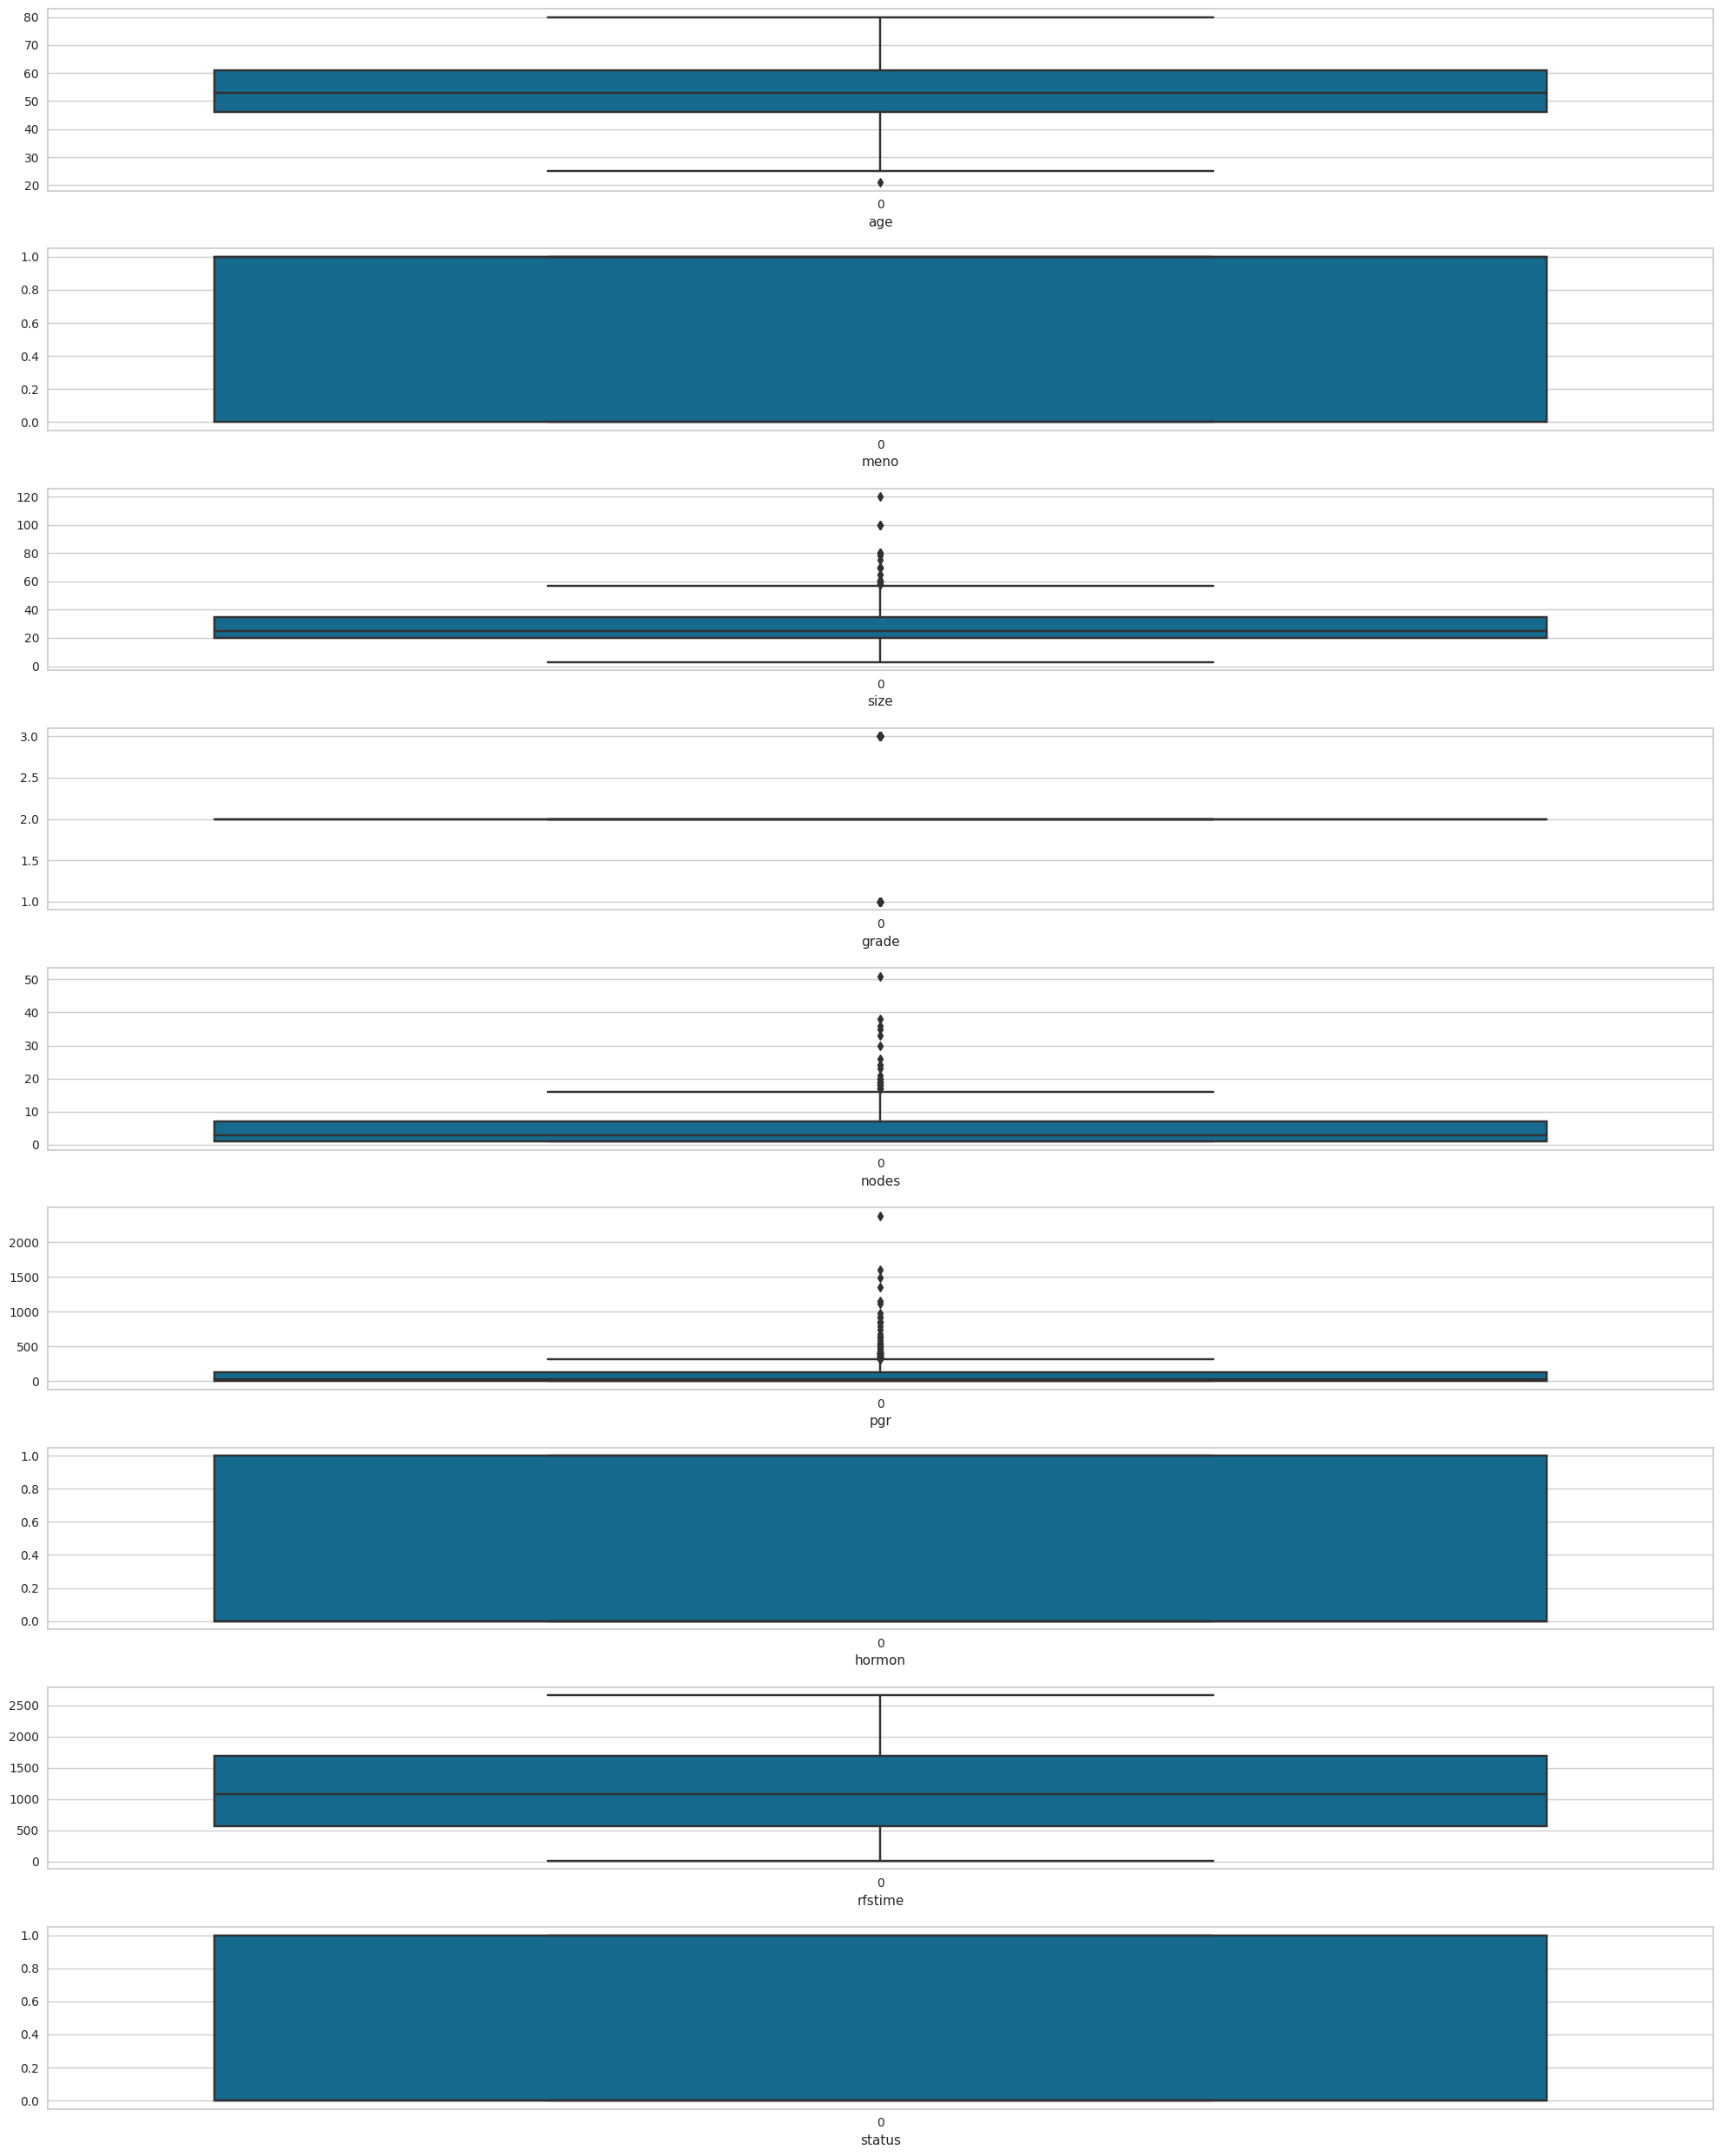

In [14]:
box_plot(df,col)

Co-relation

<AxesSubplot: >

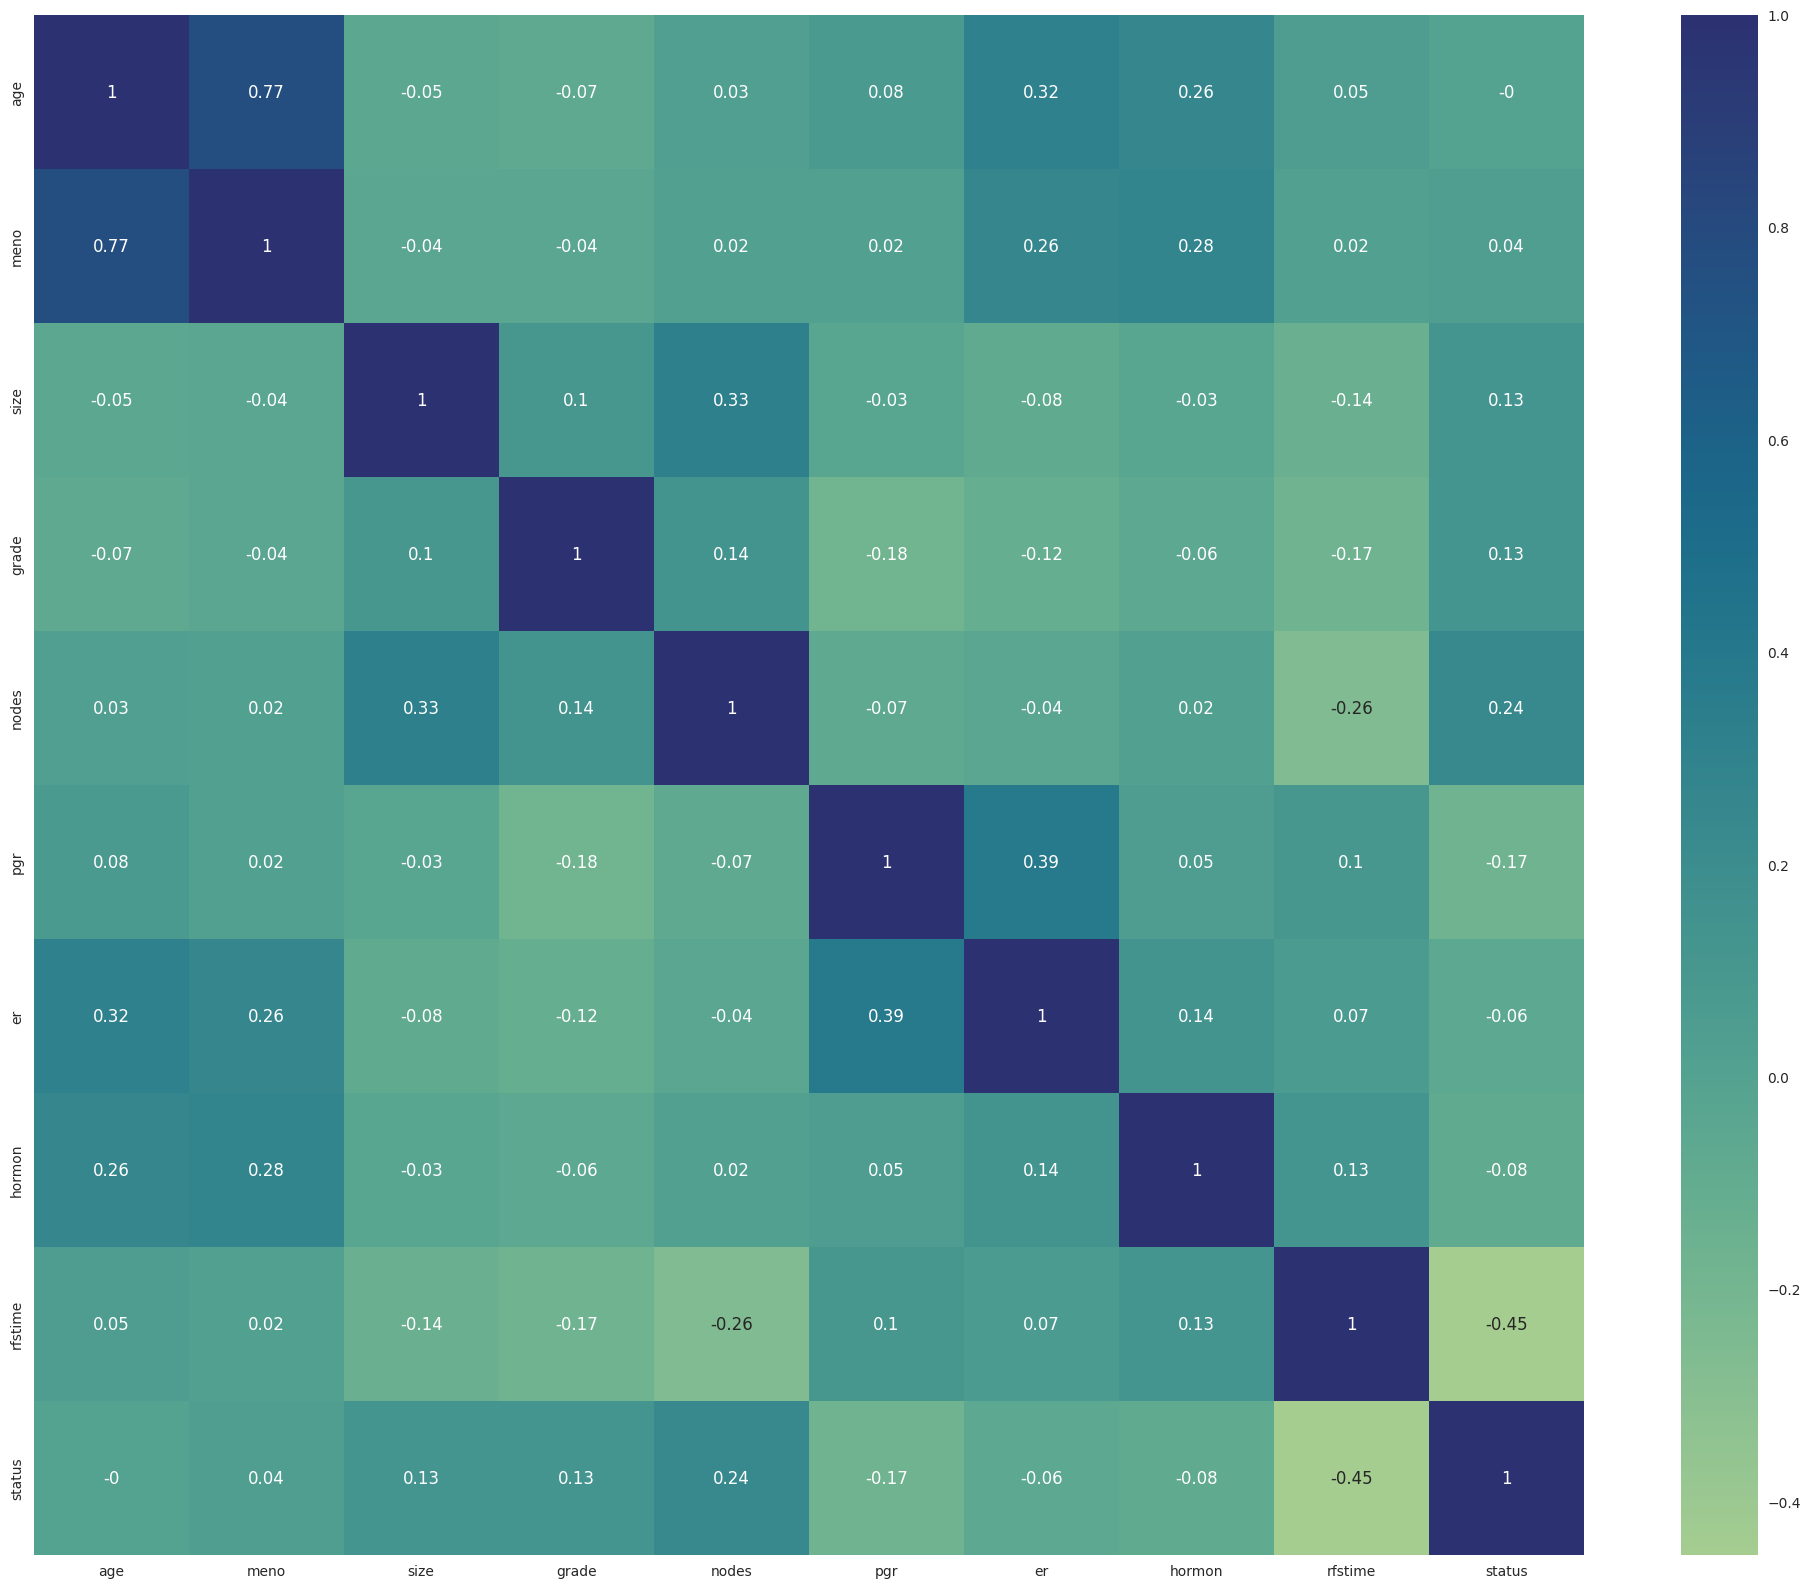

In [15]:
corr = df.corr().round(2)
plt.figure(figsize = (25,20))
sns.heatmap(corr, annot = True, cmap = 'crest')

# Remove outliers

In [16]:
df.shape

(686, 10)

In [17]:
## Remove the outliers
def drop_outliers(data,feature):
    iqr=1.5 * (np.percentile(data[feature],90)-np.percentile(data[feature],10))
    data.drop(data[data[feature]> (iqr+np.percentile(data[feature],90))].index,inplace=True)
    data.drop(data[data[feature]< (np.percentile(data[feature],10)-iqr)].index,inplace=True)

In [18]:
# apply outlier removal to each numeric feature
for feature in col:
    drop_outliers(df, feature)

In [19]:
df.shape

(666, 10)

In [20]:
X=df.drop('status',axis=1)
X=X.values
y=df['status']

In [21]:
X

array([[  49,    0,   18, ...,    0,    0, 1838],
       [  55,    1,   20, ...,    0,    0,  403],
       [  56,    1,   40, ...,    0,    0, 1603],
       ...,
       [  51,    1,    4, ...,  232,    1,  461],
       [  46,    1,   20, ...,  152,    0, 1814],
       [  59,    1,   45, ...,  526,    0,  740]])

# Spliting the data

In [22]:
X_train,X_test,y_train,y_test=train_test_split(X,y,test_size=0.2,random_state=42)

In [23]:
X_train.shape,y_train.shape

((532, 9), (532,))

In [24]:
X_test.shape,y_test.shape

((134, 9), (134,))

# Normalization

#### ScandardScale is used to put the data into same scale


In [25]:
scaler=StandardScaler()
X_train_std=scaler.fit_transform(X_train)
X_test_std=scaler.fit(X_test)

In [26]:
X_train_std

array([[-1.47337707, -1.15470054, -0.43547709, ..., -0.62055221,
        -0.74230749,  0.92100953],
       [-0.37946656, -1.15470054, -0.66365222, ...,  0.0682872 ,
         1.34715063,  1.3494409 ],
       [ 0.41610472,  0.8660254 ,  1.61809906, ..., -0.31356943,
        -0.74230749, -1.58378389],
       ...,
       [ 1.01278317,  0.8660254 ,  1.23780718, ...,  0.03085028,
        -0.74230749, -1.2670507 ],
       [-0.37946656,  0.8660254 , -0.58759385, ...,  0.47260599,
        -0.74230749,  0.91335897],
       [ 0.91333676,  0.8660254 ,  1.61809906, ..., -0.65050175,
         1.34715063, -1.15688263]])

# Model Selection

In [27]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import BaggingClassifier
from xgboost import XGBClassifier
from sklearn.model_selection import RandomizedSearchCV,GridSearchCV

# Hyper-parameter tunning

In [28]:
lr=LogisticRegression(random_state=42)
knn=KNeighborsClassifier()
dt=DecisionTreeClassifier()
rf=RandomForestClassifier()
ada=AdaBoostClassifier()
xgb=XGBClassifier(eval_metric='logloss',use_label_encoder=False)

# parameter for KNN
para_knn={'n_neighbors':np.arange(1,50)}
grid_knn=GridSearchCV(knn,param_grid=para_knn,cv=5)

#parameter for decision tree
para_dt={'criterion':['gini','entropy'],'max_depth':np.arange(1,50),
         'min_samples_leaf':[1,2,4,5,10,20,30,40,50,80,100]}
grid_dt=GridSearchCV(dt,param_grid=para_dt,cv=5)

#parameter for Random Forest
params_rf={'n_estimators':[100,200,350,500],
           'min_samples_leaf':[2,10,30,50,80,100]}
grid_rf=GridSearchCV(rf,param_grid=params_rf,cv=5)

#parameters for AdaBoost
params_ada={'n_estimators':[50,100,250,400,500],
            'learning_rate':[0.1,0.001,0.2,0.5,0.8,1]}
grid_ada=GridSearchCV(ada,param_grid=params_ada,cv=5)

# paraameter for XGBoost
params_xgb={'n_estimators':[50,100,250,600,800,1000],
           'learning_rate':[0.1,0.001,0.2,0.5,0.8,1]}
rs_xgb=RandomizedSearchCV(xgb,param_distributions=params_xgb,cv=5)

/opt/conda/lib/python3.10/site-packages/xgboost/sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")


# Finding the best parameters

In [29]:
grid_knn.fit(X_train,y_train)
grid_dt.fit(X_train,y_train)
grid_rf.fit(X_train,y_train)
grid_ada.fit(X_train,y_train)
rs_xgb.fit(X_train,y_train)

print("Best parameters for KNN:", grid_knn.best_params_)
print("Best parameters for Decision Tree:", grid_dt.best_params_)
print("Best parameters for Random Forest:", grid_rf.best_params_)
print("Best parameters for AdaBoost:", grid_ada.best_params_)
print("Best parameters for XGBoost:", rs_xgb.best_params_)

/opt/conda/lib/python3.10/site-packages/xgboost/sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")
/opt/conda/lib/python3.10/site-packages/xgboost/sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")
/opt/conda/lib/python3.10/site-packages/xgboost/sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")
/opt/conda/lib/python3.10/site-packages/xgboost/sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")
/opt/conda/lib/python3.10/site-packages/xgboost/sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")
/opt/conda/lib/python3.10/site-packages/xgboost/sklearn.py:1395: UserWarnin

Best parameters for KNN: {'n_neighbors': 16}
Best parameters for Decision Tree: {'criterion': 'entropy', 'max_depth': 4, 'min_samples_leaf': 5}
Best parameters for Random Forest: {'min_samples_leaf': 2, 'n_estimators': 100}
Best parameters for AdaBoost: {'learning_rate': 0.1, 'n_estimators': 500}
Best parameters for XGBoost: {'n_estimators': 800, 'learning_rate': 0.1}


#### Applying these in our models

In [30]:
lr=LogisticRegression(random_state=42)
dt=DecisionTreeClassifier(criterion='entropy',max_depth=4,min_samples_leaf=5,random_state=42)
knn=KNeighborsClassifier(n_neighbors=16)
rf=RandomForestClassifier(n_estimators=100,min_samples_leaf=2,random_state=42)
ada=AdaBoostClassifier(n_estimators=500,learning_rate=0.1)
xgb=XGBClassifier(n_estimators=800,learning_rate=0.1)

In [31]:
classifiers = [('Logistic Regression', lr), ('K Nearest Neighbours', knn),
               ('Decision Tree', dt), ('Random Forest', rf), ('AdaBoost', ada),
               ('XGBoost', xgb)]

In [32]:
from sklearn.metrics import accuracy_score
for classifier_name , classifier in classifiers:
    #Fit classifier to training set
    classifier.fit(X_train,y_train)
    
    #predict y_pred
    y_pred=classifier.predict(X_test)
    accuracy=accuracy_score(y_test,y_pred)
    
    #Evaluation the test set
    print('{:s} : {:.2f}'.format(classifier_name, accuracy))

/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Logistic Regression : 0.73
K Nearest Neighbours : 0.77
Decision Tree : 0.76
Random Forest : 0.79
AdaBoost : 0.76
XGBoost : 0.70


#### We can see from the accuracy score that the most predicted accuracy score is 79% which we can find in Random Forest Classifier model

In [33]:
def print_classifier_reports(classifiers, X_train, y_train, X_test, y_test):
    for name, clf in classifiers:
        clf.fit(X_train, y_train)
        y_pred = clf.predict(X_test)
        print(f"Classification report for {name}:")
        print(classification_report(y_test, y_pred))

print_classifier_reports(classifiers, X_train, y_train, X_test, y_test)

/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Classification report for Logistic Regression:
              precision    recall  f1-score   support

           0       0.72      0.80      0.76        71
           1       0.75      0.65      0.69        63

    accuracy                           0.73       134
   macro avg       0.73      0.73      0.73       134
weighted avg       0.73      0.73      0.73       134

Classification report for K Nearest Neighbours:
              precision    recall  f1-score   support

           0       0.72      0.93      0.81        71
           1       0.88      0.59      0.70        63

    accuracy                           0.77       134
   macro avg       0.80      0.76      0.76       134
weighted avg       0.79      0.77      0.76       134

Classification report for Decision Tree:
              precision    recall  f1-score   support

           0       0.72      0.90      0.80        71
           1       0.84      0.60      0.70        63

    accuracy                           0.76   

make plot here

Confusion Matrix use for true false positive negetive
Precision recall f1 score

/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


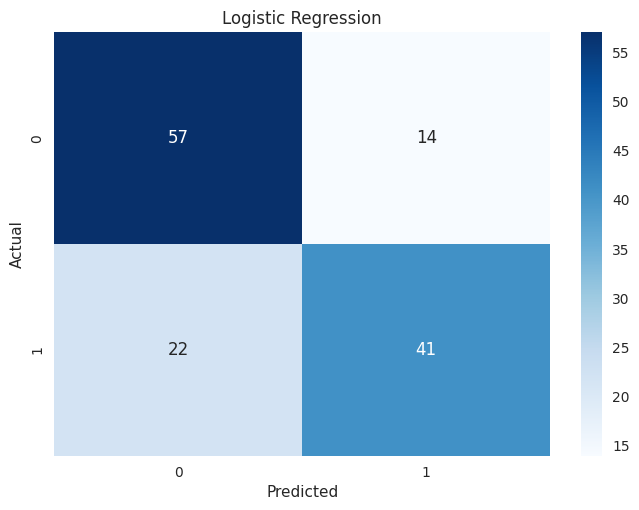

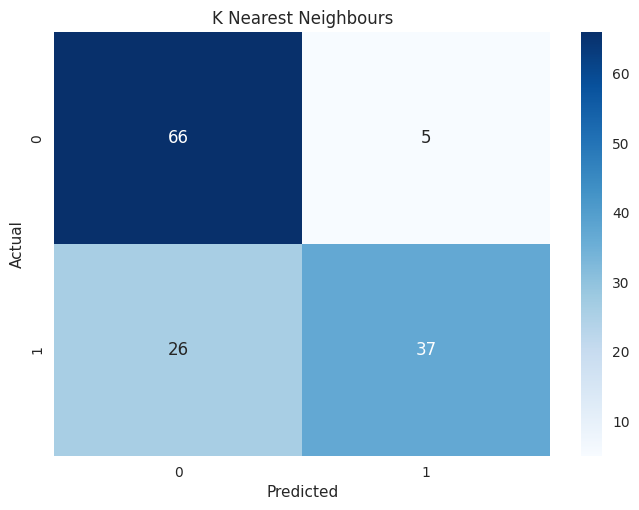

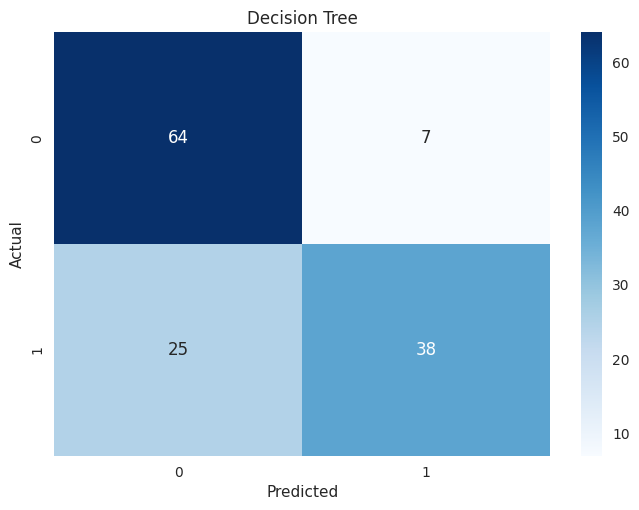

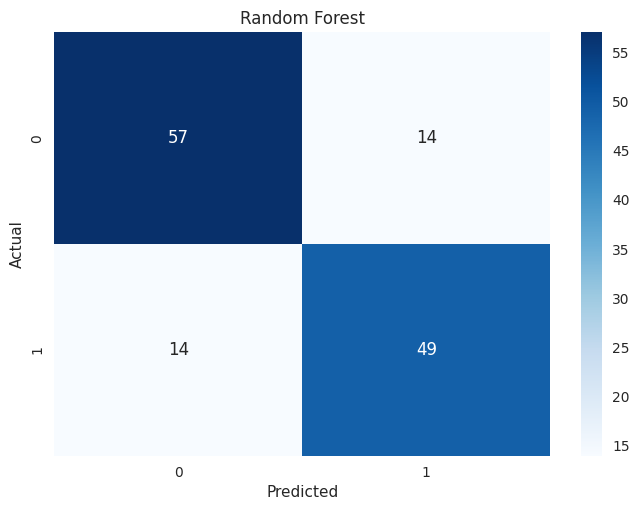

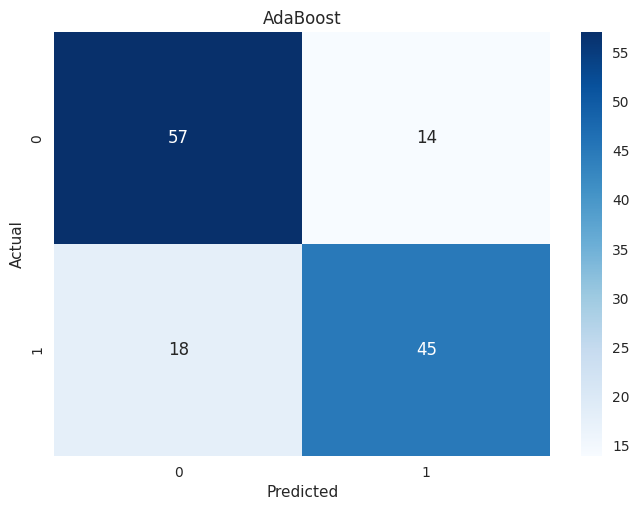

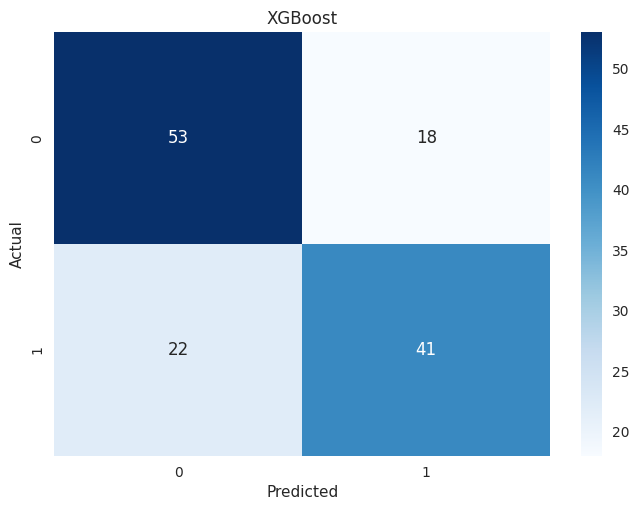

In [34]:
def print_confusion_matrix(classifiers, X_train, y_train, X_test, y_test):
    for name, clf in classifiers:
      clf.fit(X_train,y_train)
      y_pred=clf.predict(X_test)
      cm=confusion_matrix(y_test,y_pred)
      ax = plt.subplot()
      sns.heatmap(cm, annot=True, ax=ax, cmap='Blues')
      ax.set_xlabel('Predicted')
      ax.set_ylabel('Actual')
      ax.set_title(name)
      plt.show()

print_confusion_matrix(classifiers, X_train, y_train, X_test, y_test)